# Feb 9, 2025: check if chains have converged

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob
from numba import jit
import arviz as az
import re

from itertools import product, combinations
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
from cycler import cycler
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

# import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

def setup_plotting(palette=None, context="paper", fontsize=7):
    """
    Configure seaborn with 'paper' context and synced matplotlib rcParams.
    """
    setup_mpl(fontsize)

    if palette is None:
        try:
            from cycler import cycler
            cycle = mpl.rcParams['axes.prop_cycle']
            palette = [d['color'] for d in cycle]
        except Exception:
            palette = sns.color_palette("colorblind")

    sns.set_theme(
        context=context,       # use "paper"
        style="white", 
        palette=palette, 
        rc=mpl.rcParams
    )

    setup_mpl(fontsize)

In [3]:
# setup_plotting(context='paper', fontsize=7)
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

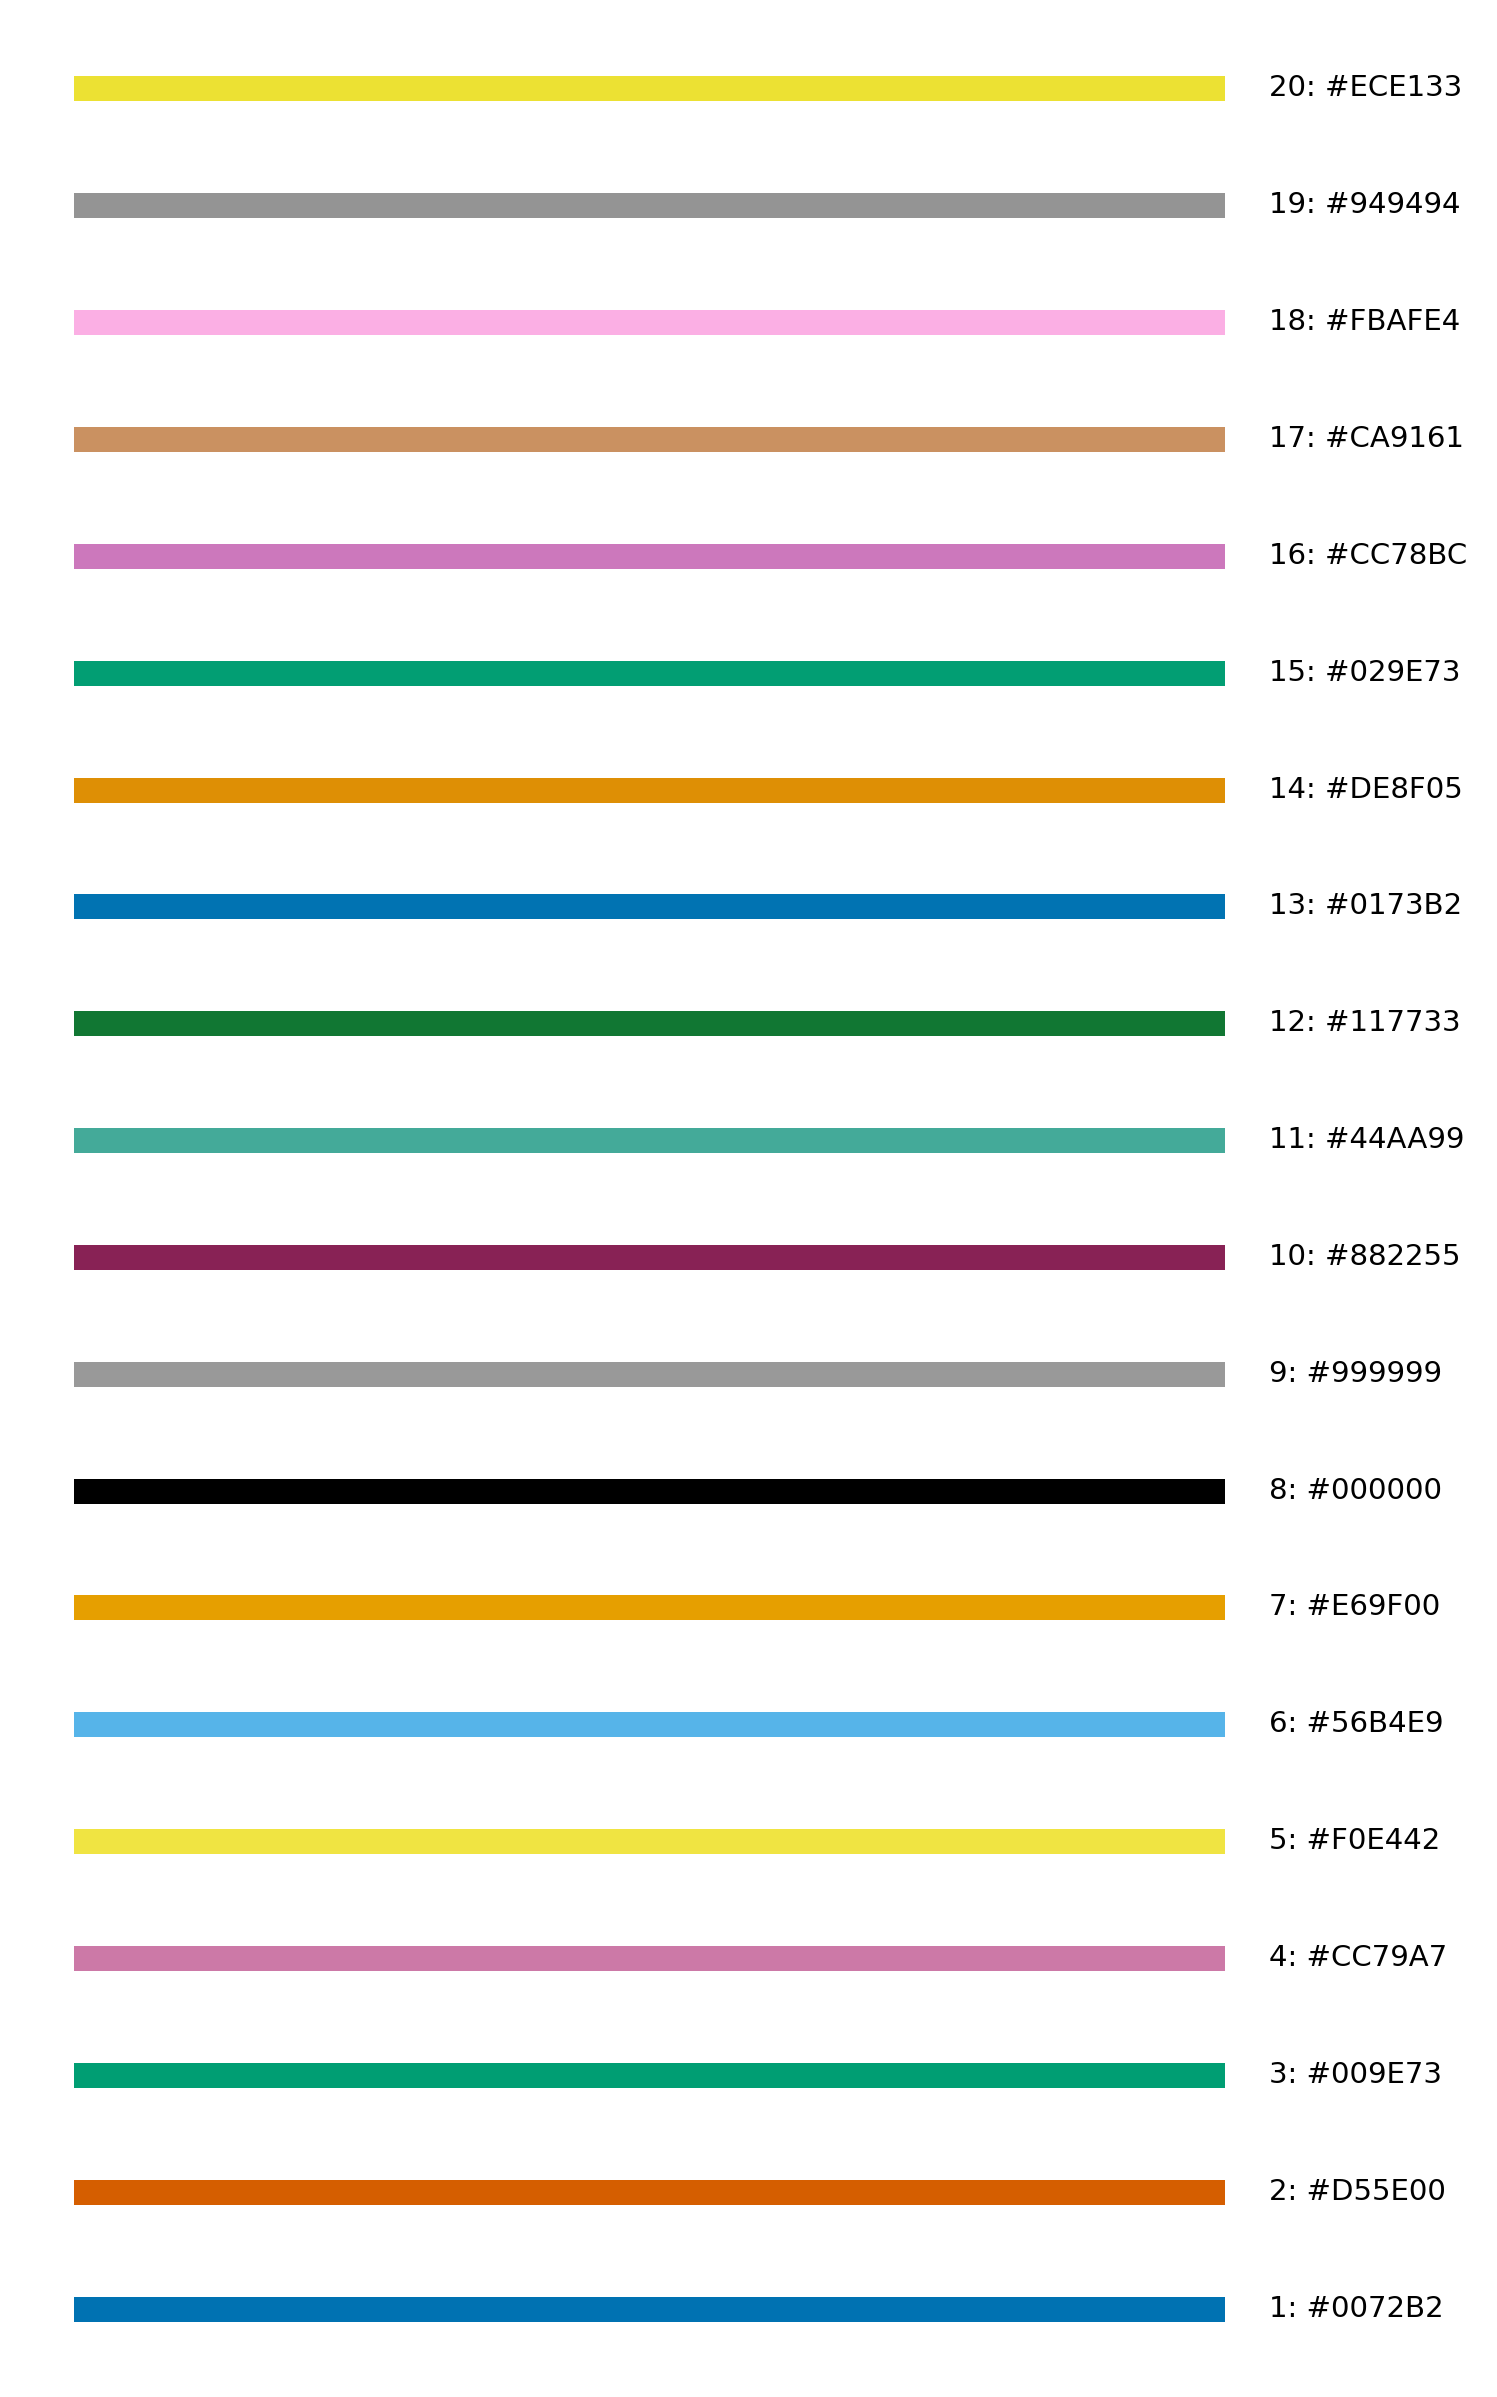

In [4]:
def preview_colorblind_palette():
    colors = get_colorblind_palette()
    n = len(colors)
    
    fig, ax = plt.subplots(figsize=(5, 0.4 * n))
    for i, color in enumerate(colors):
        ax.plot([0, 1], [i, i], color=color, linewidth=6)
        ax.text(1.05, i, f"{i+1}: {color}", va='center', ha='left', fontsize=7)
    
    ax.set_ylim(-0.5, n - 0.5)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
preview_colorblind_palette()

| Color     | HEX       | Use |
|-----------|-----------|-----|
| Blue      | `#0072B2` | Chain 1 |
| Vermilion | `#D55E00` | Chain 2 |
| Green     | `#009E73` | Chain 3 |
| Purple    | `#CC79A7` | Chain 4 |
| Yellow    | `#F0E442` | Chain 5 |
| Light Blue| `#56B4E9` | Chain 6 |
| Orange    | `#E69F00` | Chain 7 |
| Black     | `#000000` | Chain 8 |

In [5]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [6]:
args.source = 'allen' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #334 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [7]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')

0

In [8]:
SBM_path

'/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/model-fits'

In [9]:
args.dc, args.sbm = False, 'h'

args.force_niter = 3000 if args.sbm in ['o'] else 100000 #40000 
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence
args.delta = np.ceil(args.force_niter / 100).astype(int)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

In [10]:
def collect_sbm_files(args, sbm_files):
    sbms_df = []
    for file in tqdm(sbm_files):
        try:
            with open(file, 'rb') as f:
                [bs, Bs, Bes, dls] = pickle.load(f)
            
            fs = file.split('/')
            sub = '-'.join([s for s in fs if 'sub-' in s][0].split('-')[1:])
            sbm = [s for s in fs if 'sbm-' in s][0]
            B = [s for s in fs if 'B-' in s][0].split('-')[-1]

            Bes = Bes[0] if args.sbm in ['h'] else Bes
            
            row = pd.DataFrame(dict(
                sub=[sub],
                sbm=[sbm],
                chain=[B],
                Bes=[dls],
            ))
            sbms_df += [row]
        # break
        except:
            pass
    sbms_df = pd.concat(sbms_df).reset_index(drop=True)
    return sbms_df

sbm_files = sorted(glob.glob(f'{SBM_path}/*/{SBM}/*/desc-partitions.pkl', recursive=True))
# sbm_files = sorted(glob.glob(f'{SBM_path}/*/{SBM}/*/desc-Bes.pkl', recursive=True))
sbms_df = collect_sbm_files(args, sbm_files)

  0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 44/44 [10:15<00:00, 13.98s/it]


In [11]:
len(sbms_df.iloc[0]['Bes']) + 1

100000

In [12]:
replacement_dict = {val: f'{i+1}' for i, val in enumerate(sbms_df['chain'].unique())}
sbms_df['chain'] = sbms_df['chain'].replace(replacement_dict)

In [13]:
sbms_df.head(n=10)

,sub,sbm,chain,Bes
0,SLC01_task-rest,sbm-nd-h,1,"[6073.950778438921, 6053.570614513826, 6045.85..."
1,SLC01_task-rest,sbm-nd-h,2,"[6044.989615540172, 6036.262103990878, 6010.63..."
2,SLC01_task-rest,sbm-nd-h,3,"[6008.298394092583, 6005.78539451881, 6003.481..."
3,SLC01_task-rest,sbm-nd-h,4,"[6011.783266514487, 6016.013062756847, 5999.46..."
4,SLC01_task-rest,sbm-nd-h,5,"[6040.068792390762, 6032.749349182644, 6028.87..."
5,SLC03_task-rest,sbm-nd-h,1,"[5973.986653287856, 5967.673650844163, 5973.34..."
6,SLC03_task-rest,sbm-nd-h,2,"[5975.383871021205, 5971.807359418581, 5961.83..."
7,SLC03_task-rest,sbm-nd-h,3,"[5945.535805559238, 5936.858450983493, 5935.28..."
8,SLC03_task-rest,sbm-nd-h,4,"[6012.813556020396, 6000.935756023179, 5991.39..."
9,SLC03_task-rest,sbm-nd-h,5,"[5981.09808609706, 5979.107585204033, 5959.159..."


In [14]:
def KSD(args, chains_df):
    chain_idxs = chains_df.index.to_list()
    
    ksds_df = []
    for idx1, idx2 in (combinations(chain_idxs, 2)):
        Bes_ch1 = chains_df.iloc[idx1]['Bes']
        Bes_ch2 = chains_df.iloc[idx2]['Bes']
        Ds = []
        ts = np.arange(10, args.force_niter, args.delta)
        for t in ts:
            res = stats.ks_2samp(Bes_ch1[:t], Bes_ch2[:t])
            Ds.append(res.statistic)
        df = pd.DataFrame({
            'ch1': [idx1] * len(Ds),
            'ch2': [idx2] * len(Ds),
            't': ts,
            'D': Ds,
        })
        ksds_df.append(df)
    ksds_df = pd.concat(ksds_df).reset_index(drop=True)
    return ksds_df

def plot_KSD(args, chains_df, ksds_df, ax):
    chain_idxs = chains_df.index.to_list()
    Ds = []
    for idx1, idx2 in combinations(chain_idxs, 2):
        t_D = ksds_df[
            (ksds_df['ch1'] == idx1) &
            (ksds_df['ch2'] == idx2)
        ][['t', 'D']].to_numpy()
        Ds += [t_D[:, 1]]
        if (idx1, idx2) == (1, 2):
            ax.plot(t_D[:, 0], t_D[:, 1], c=CUD_COLORS[0], alpha=0.5, label='pair of chains')
        else:
            ax.plot(t_D[:, 0], t_D[:, 1], c=CUD_COLORS[0], alpha=0.5)
        
    Ds = np.stack(Ds, axis=-1)
    ax.plot(t_D[:, 0], np.mean(Ds, axis=-1), c=CUD_COLORS[1], label='mean')
    ax.plot(t_D[:, 0], args.epsilon * np.ones_like(t_D[:, 0]), c='#999999', linestyle='--', label=f'convergence \nthreshold')
    ax.axvline(x=args.num_draws, color='#CA9161', linestyle='--', label='midpoint')
    T = Ds.shape[0]
    return np.all(Ds[T//2:, :] < args.epsilon)

def indicate_unmizing(args, ax):
    for spine in ax.spines.values():
        spine.set_color('tab:red')
        spine.set_linewidth(2)
    return None

def change_axes_thickness(args, ax, thickness=0.5):
    for spine in ax.spines.values():
        spine.set_linewidth(thickness)
    ax.tick_params(width=0.5, length=2.5)

def trace_plot(args, group, ax):
    for i, r in group.iterrows():
        ax.plot(r['Bes'], label=r['chain'])
    return None

def Rhat(args, chains_df):
    chain_idxs = chains_df.index.to_list()
    chains = np.stack(chains_df['Bes'].to_list(), axis=0)
    
    ts = np.arange(10, chains.shape[-1], args.delta)
    rhats = np.zeros_like(ts)
    for i, t in enumerate(ts):
        rhats[i] = az.rhat(chains[:, :t])
    return ts, rhats

In [15]:
def create_diagnostics_plots(args, sbms_df):
    ncols = 4
    nrows = len(sbms_df['sub'].unique())
    a = 20/9
    b = a*4/7
    fig, axs = plt.subplots(
        nrows=nrows, ncols=ncols, 
        figsize=(a*ncols+a/2, b*nrows), # inches
        width_ratios=[1.5, 1, 1, 1],
    )
    fig.tight_layout(h_pad=0, w_pad=0)

    for idx, (sub, group) in tqdm(enumerate(sbms_df.groupby(by=['sub']))):
        sub = sub[0]
        group = group.reset_index(drop=True)
        group['Bes_conv'] = group['Bes'].apply(lambda x: x[-args.num_draws:])
        display(group)

        # Koomogorov-Smirnov distances
        ax = axs[idx, 1]
        ksds_df = KSD(args, group)
        converged = plot_KSD(args, group, ksds_df, ax)
        # ax.set(xlabel=f'MCMC step', ylabel=f'K-S distance')
        ax.set(xlabel=f'', ylabel=f'', xticklabels=[], ylim=[0, 1])
        ax.legend()
        ax.grid(alpha=0.15)
        # if not converged: indicate_unmizing(args, ax)
        # change_axes_thickness(args, ax, thickness=0.5)
        
        # trace plots
        ax = axs[idx, 0]
        trace_plot(args, group, ax)
        # ax.set(title=f'sub-{sub}', ylabel='$B_e$', xlabel='MCMC step')
        ax.set(title=f'sub-{sub}', ylabel=f'', xlabel=f'')
        ax.legend(title='chain')
        # if not converged: indicate_unmizing(args, ax)
        # change_axes_thickness(args, ax, thickness=0.5)

        # Rhat
        ax = axs[idx, 3]
        ts, rhats = Rhat(args, group)
        ax.plot(ts, rhats)
        # ax.set(xlabel=f'MCMC step', ylabel='$\hat{R}$')
        ax.set(xlabel=f'', ylabel=f'')
        # if not converged: indicate_unmizing(args, ax)
        # change_axes_thickness(args, ax, thickness=0.5)

        # posterior distribution
        ax = axs[idx, 2]
        df = group.explode('Bes_conv')
        sns.kdeplot(data=df, x='Bes_conv', hue='chain', palette=CUD_COLORS, fill=True, alpha=0.1, ax=ax)
        # ax.set(xlabel='$B_{e}$', ylabel='posterior density')
        ax.set(xlabel=f'', ylabel=f'', yticklabels=[])
        ax.tick_params(axis='y', which='major', length=0.25)
        ax.grid(alpha=0.15)
        xmin, xmax = ax.get_xlim()
        xticks = np.linspace(xmin, xmax, 5)
        ax.set_xticks([np.ceil(xt) for xt in xticks])
        # ax.legend().set_visible(False)
        # if not converged: indicate_unmizing(args, ax)
        # change_axes_thickness(args, ax, thickness=0.5)
    return fig

0it [00:00, ?it/s]

,sub,sbm,chain,Bes,Bes_conv
0,SLC01_task-rest,sbm-nd-h,1,"[6073.950778438921, 6053.570614513826, 6045.85...","[5979.178586091921, 5982.843154573748, 5984.23..."
1,SLC01_task-rest,sbm-nd-h,2,"[6044.989615540172, 6036.262103990878, 6010.63...","[5975.527090523716, 5971.4297721873145, 5976.0..."
2,SLC01_task-rest,sbm-nd-h,3,"[6008.298394092583, 6005.78539451881, 6003.481...","[5970.737676280955, 5975.00315294911, 5989.009..."
3,SLC01_task-rest,sbm-nd-h,4,"[6011.783266514487, 6016.013062756847, 5999.46...","[5984.684105923683, 5982.891133018704, 5972.34..."
4,SLC01_task-rest,sbm-nd-h,5,"[6040.068792390762, 6032.749349182644, 6028.87...","[5979.665241829076, 5984.516919735419, 5978.58..."


1it [00:41, 41.77s/it]

,sub,sbm,chain,Bes,Bes_conv
0,SLC03_task-rest,sbm-nd-h,1,"[5973.986653287856, 5967.673650844163, 5973.34...","[5916.154850122597, 5916.715947470148, 5908.88..."
1,SLC03_task-rest,sbm-nd-h,2,"[5975.383871021205, 5971.807359418581, 5961.83...","[5917.219362843481, 5917.670095611735, 5919.04..."
2,SLC03_task-rest,sbm-nd-h,3,"[5945.535805559238, 5936.858450983493, 5935.28...","[5922.982120176989, 5925.333158471076, 5917.87..."
3,SLC03_task-rest,sbm-nd-h,4,"[6012.813556020396, 6000.935756023179, 5991.39...","[5912.5122389768985, 5913.162378564209, 5916.9..."
4,SLC03_task-rest,sbm-nd-h,5,"[5981.09808609706, 5979.107585204033, 5959.159...","[5917.225950887944, 5910.155837443162, 5910.20..."


2it [01:11, 34.95s/it]

,sub,sbm,chain,Bes,Bes_conv
0,SLC04_task-rest,sbm-nd-h,1,"[6018.236016457532, 6011.306468981764, 5997.68...","[5949.846005918335, 5946.786464623068, 5961.32..."
1,SLC04_task-rest,sbm-nd-h,2,"[5974.350132388542, 5984.271870487872, 5973.04...","[5947.552680538976, 5953.042112402068, 5949.19..."
2,SLC04_task-rest,sbm-nd-h,3,"[5979.8676182793815, 5976.594821564315, 5974.7...","[5940.561689162579, 5948.627295178603, 5948.63..."
3,SLC04_task-rest,sbm-nd-h,4,"[5982.493531047989, 5987.530750770383, 5976.18...","[5947.222037128361, 5950.2481367113405, 5953.9..."
4,SLC04_task-rest,sbm-nd-h,5,"[6025.019628607053, 6021.986252003701, 6019.28...","[5958.747607451259, 5945.357799116246, 5947.31..."


3it [01:49, 36.24s/it]

,sub,sbm,chain,Bes,Bes_conv
0,SLC05_task-rest,sbm-nd-h,1,"[6265.051930220285, 6252.740026366749, 6230.14...","[6215.248879054684, 6204.113115419067, 6196.96..."
1,SLC05_task-rest,sbm-nd-h,2,"[6238.80414998937, 6227.152510010671, 6236.927...","[6182.810004076089, 6184.477585276104, 6186.81..."
2,SLC05_task-rest,sbm-nd-h,3,"[6231.413272094447, 6225.0259032282665, 6230.0...","[6202.261648329638, 6200.343789166711, 6204.63..."
3,SLC05_task-rest,sbm-nd-h,4,"[6251.156778206231, 6257.355928800359, 6256.67...","[6204.5502666146, 6198.3957579417465, 6201.227..."
4,SLC05_task-rest,sbm-nd-h,5,"[6269.142664699348, 6246.586127183178, 6247.22...","[6188.106636455046, 6193.750693467944, 6191.21..."


4it [02:30, 38.11s/it]

,sub,sbm,chain,Bes,Bes_conv
0,SLC06_task-rest,sbm-nd-h,2,"[5861.515238924456, 5854.699906713693, 5848.14...","[5845.322109132829, 5852.0465350864, 5833.8932..."
1,SLC06_task-rest,sbm-nd-h,3,"[5852.032967558931, 5851.090466136269, 5844.36...","[5832.938134706368, 5829.494295362205, 5828.07..."
2,SLC06_task-rest,sbm-nd-h,4,"[5883.258776757071, 5870.624748341224, 5867.78...","[5827.477248027631, 5826.955545097905, 5827.81..."
3,SLC06_task-rest,sbm-nd-h,5,"[5847.5672936557985, 5854.108705240954, 5843.3...","[5829.943878153251, 5830.298088072591, 5829.38..."


5it [02:56, 33.72s/it]

,sub,sbm,chain,Bes,Bes_conv
0,SLC07_task-rest,sbm-nd-h,1,"[5930.117258948428, 5919.338151861335, 5915.27...","[5883.743229681306, 5884.218874416095, 5890.08..."
1,SLC07_task-rest,sbm-nd-h,2,"[5926.79537433606, 5920.580820517214, 5926.596...","[5875.8382182481, 5882.662059708951, 5877.6746..."
2,SLC07_task-rest,sbm-nd-h,3,"[5926.979491789807, 5925.23831343992, 5924.502...","[5881.69360956111, 5888.796817809263, 5889.650..."
3,SLC07_task-rest,sbm-nd-h,4,"[5946.498768274664, 5937.090525546406, 5923.32...","[5888.508212951784, 5881.280714059891, 5888.83..."
4,SLC07_task-rest,sbm-nd-h,5,"[5933.326275677343, 5919.00374315073, 5922.431...","[5883.051916385808, 5885.3193450215285, 5883.5..."


6it [03:36, 35.95s/it]

,sub,sbm,chain,Bes,Bes_conv
0,SLC08_task-rest,sbm-nd-h,1,"[6036.906728459412, 6024.635105840446, 6017.47...","[5975.303443071643, 5979.006121774602, 5981.23..."
1,SLC08_task-rest,sbm-nd-h,2,"[6048.097563031857, 6024.799108201463, 6028.13...","[5975.423980802662, 5977.024143642967, 5978.76..."
2,SLC08_task-rest,sbm-nd-h,3,"[6035.889435961857, 6021.440750674053, 6017.55...","[5983.0948833534285, 5974.972899343407, 5977.0..."
3,SLC08_task-rest,sbm-nd-h,4,"[6045.159345020102, 6039.845433185883, 6037.96...","[5980.182370846158, 5975.602588364898, 5976.15..."
4,SLC08_task-rest,sbm-nd-h,5,"[6029.24760918549, 6036.550830566268, 6042.970...","[6000.751183640597, 5996.848528478739, 5997.19..."


7it [04:19, 38.00s/it]

,sub,sbm,chain,Bes,Bes_conv
0,SLC09_task-rest,sbm-nd-h,1,"[6161.314748020736, 6169.122971164751, 6162.67...","[6095.73438464625, 6100.196759739408, 6106.252..."
1,SLC09_task-rest,sbm-nd-h,2,"[6153.997590818551, 6148.746675873126, 6144.20...","[6092.637306717566, 6091.247431196521, 6097.62..."
2,SLC09_task-rest,sbm-nd-h,3,"[6163.305609014926, 6160.995736953346, 6151.82...","[6084.288237520799, 6088.339318560606, 6096.43..."
3,SLC09_task-rest,sbm-nd-h,4,"[6146.2480232535, 6142.76081660083, 6139.67721...","[6089.0096008493565, 6089.132093173463, 6088.9..."
4,SLC09_task-rest,sbm-nd-h,5,"[6161.872394277776, 6159.724427454996, 6155.71...","[6086.115799887964, 6084.731084022449, 6093.52..."


8it [04:57, 38.22s/it]

,sub,sbm,chain,Bes,Bes_conv
0,SLC10_task-rest,sbm-nd-h,1,"[6087.291666266515, 6060.598497909536, 6060.86...","[6019.644055500149, 6027.800285169571, 6025.14..."
1,SLC10_task-rest,sbm-nd-h,2,"[6072.253048739025, 6061.020761423848, 6057.97...","[6019.272808086118, 6022.639231987335, 6024.66..."
2,SLC10_task-rest,sbm-nd-h,3,"[6047.154735533058, 6029.710452580397, 6033.83...","[6024.907543062432, 6022.561422162399, 6020.32..."
3,SLC10_task-rest,sbm-nd-h,4,"[6055.625427253219, 6039.628725959234, 6047.80...","[6020.654296559144, 6026.757504441521, 6020.22..."
4,SLC10_task-rest,sbm-nd-h,5,"[6054.302680668797, 6056.759308538672, 6059.02...","[6032.344395629076, 6033.243332902847, 6034.87..."


9it [05:37, 37.54s/it]


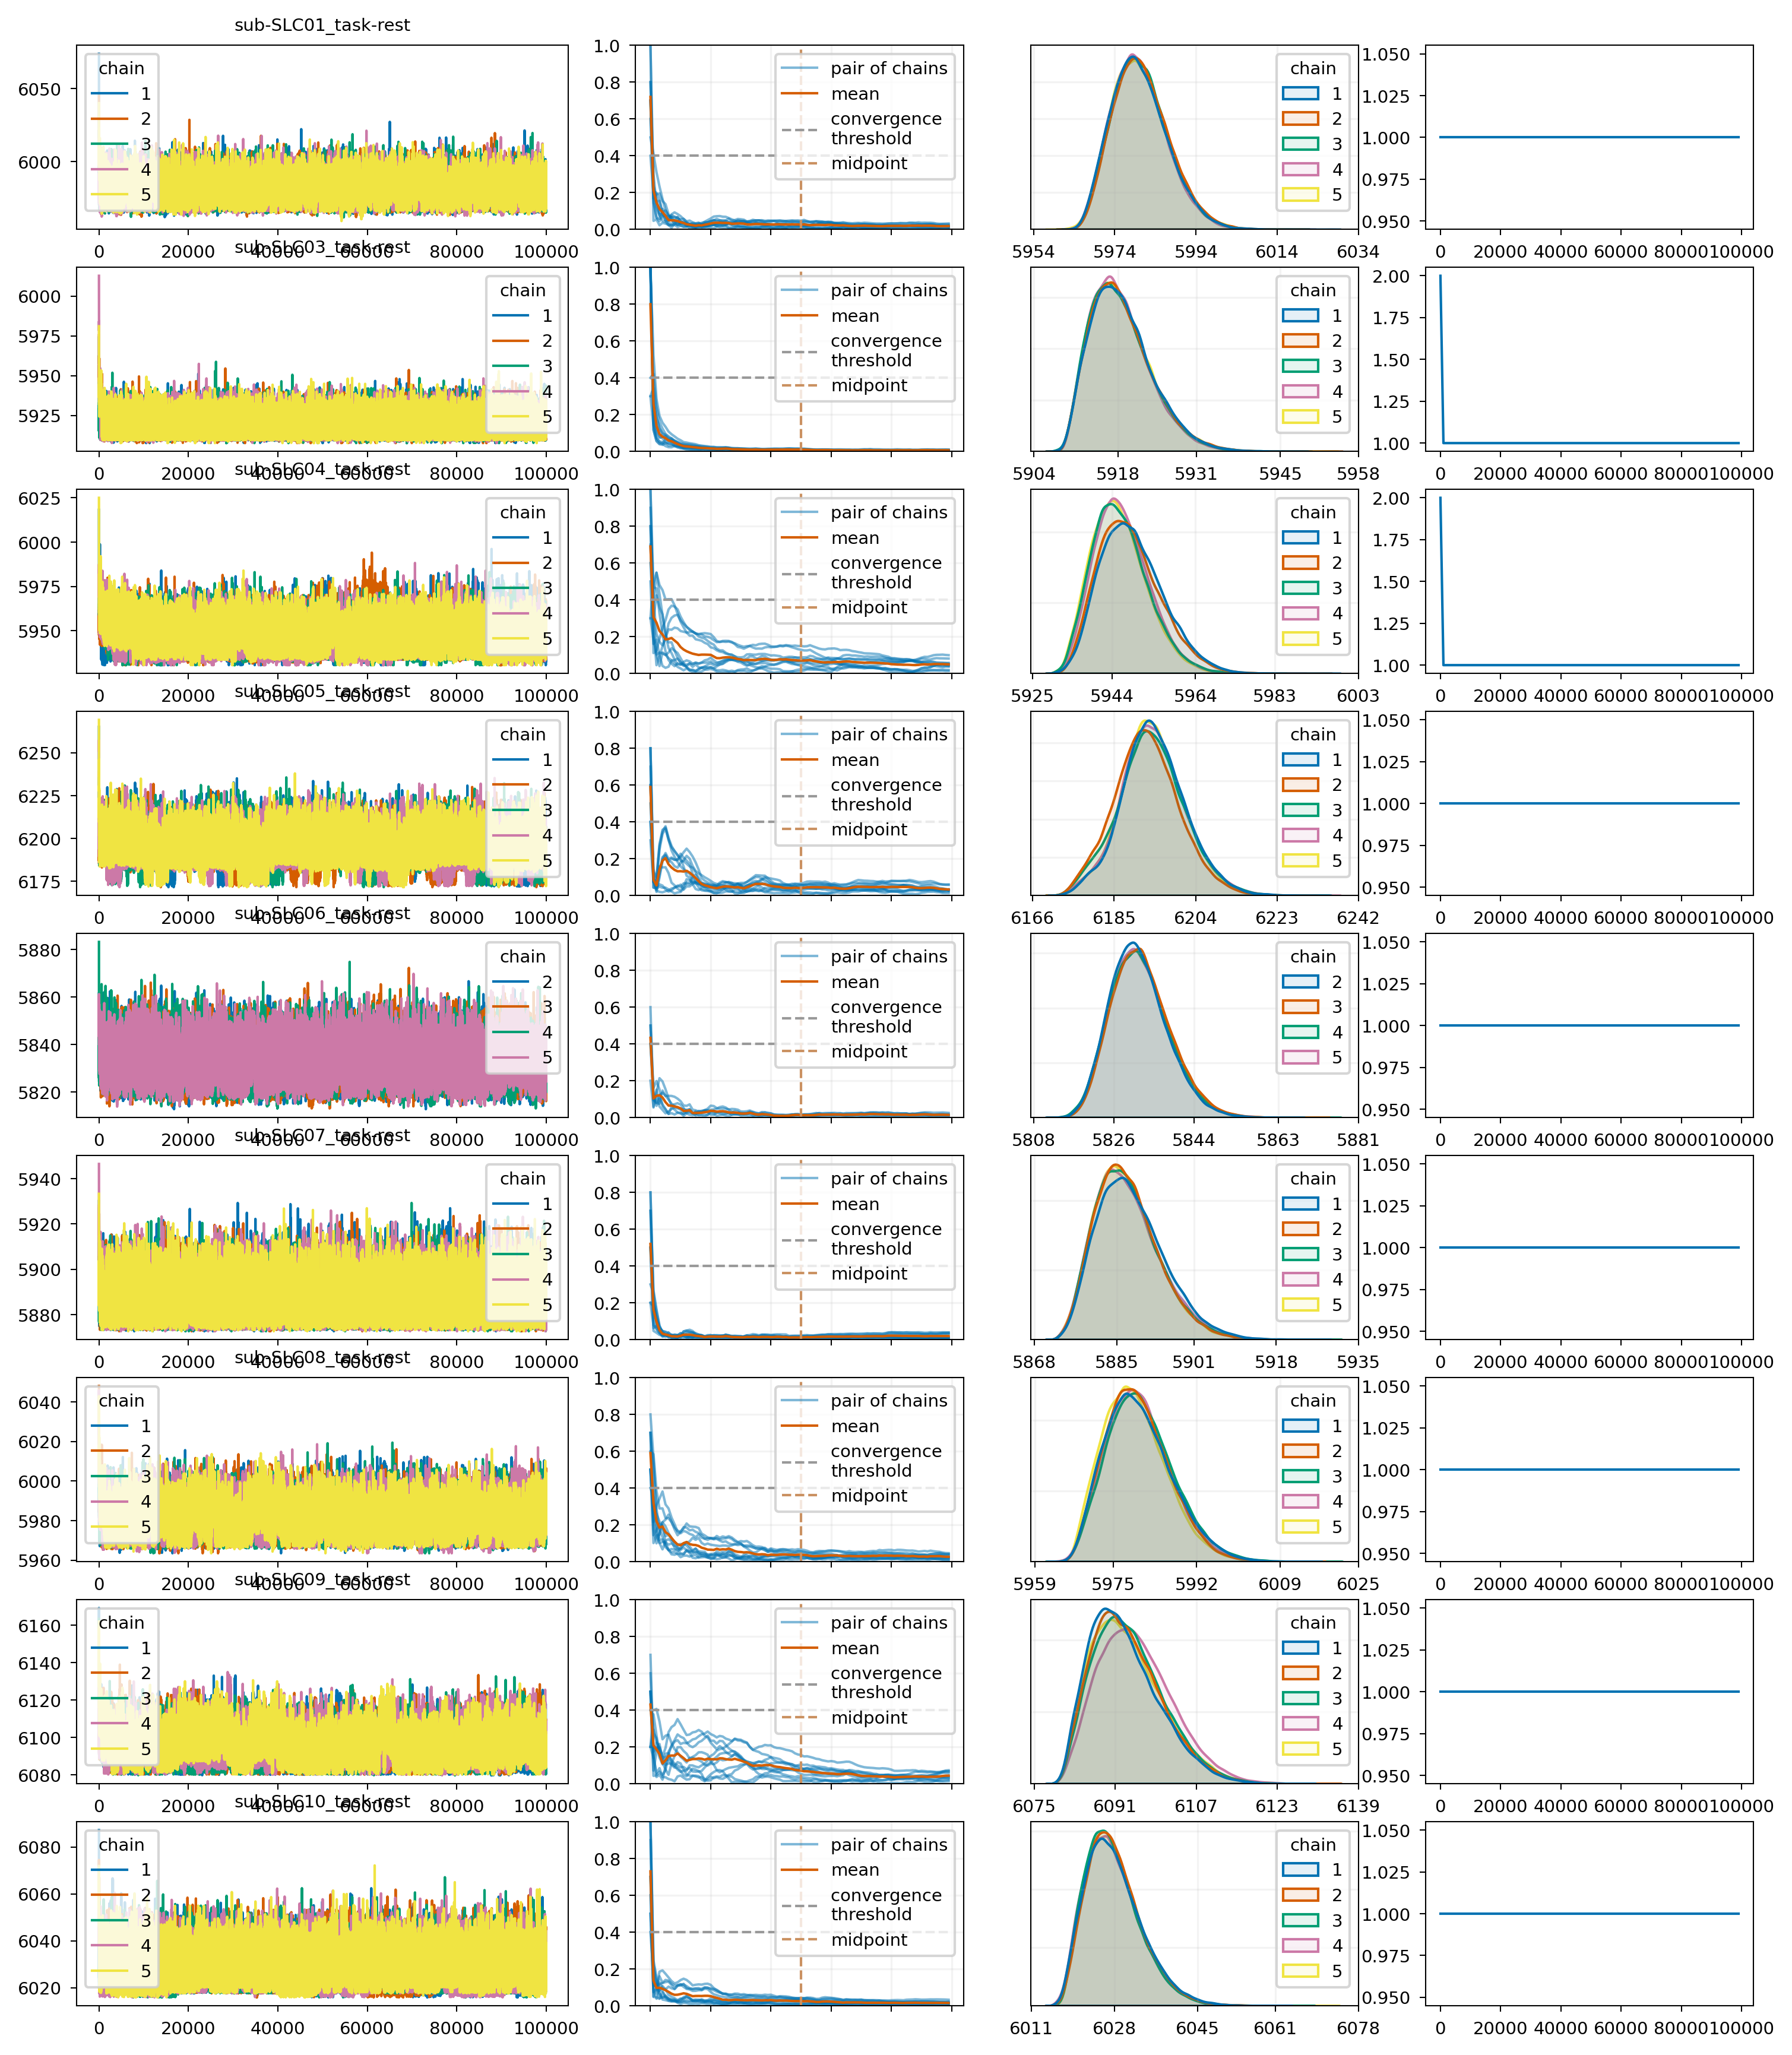

In [16]:
figfile = f'{DIAG_path}/{SBM}_desc-diagnostics.png'
if os.path.exists(figfile):
    display(Image(figfile))
else:
    fig = create_diagnostics_plots(args, sbms_df)

In [17]:
fig.savefig(f'{DIAG_path}/{SBM}_desc-trace-KSD-Rhat-dist.png', bbox_inches='tight', transparent=True)
fig.savefig(f'{DIAG_path}/{SBM}_desc-trace-KSD-Rhat-dist.svg', bbox_inches='tight', transparent=True)